# <font color="#8333ff">PROJET 5 | Classification RFM 

### Sommaire <br>

>[1-CHARGEMENT DES DONNEES](#1-CHARGEMENT-DES-DONNEES)<br>

>[2-REDUCTION DE DIMENSIONS](#2-REDUCTION-DE-DIMENSIONS)<br>

>[3-ESSAIS DES DIFFERENTS MODELES](#2-ESSAIS-DES-DIFFERENTS-MODELES)<br>
>> [KMeans](#KMeans)<br />
>> [Classification ascendante hiérarchique](#Classification-ascendante-hiérarchique)<br />
>> [K-Prototype](#K-Prototype)<br />
>> [Bilan comparatif des scores silhoutte des différents modèles](#Bilan-comparatif-des-scores-silhoutte-des-différents-modèles)<br /> 

>[4-INTERPRETATION DES RESULTATS DE CLASSIFICATION](#4-INTERPRETATION-DES-RESULTATS-DE-CLASSIFICATION)<br>
***

In [1]:
import shap
from sklearn.manifold import TSNE
from umap import UMAP
from kmodes.kprototypes import KPrototypes
from sklearn.model_selection import GridSearchCV


from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import xgboost as xgb
from sklearn.metrics import silhouette_score
import seaborn as sns
import pandas as pd
import numpy as np


from pandas.plotting import parallel_coordinates

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.offline as pyplot
init_notebook_mode(connected=True)

shap.initjs()


# https://owenhsu94.medium.com/analysis-of-brazilian-e-commerce-datasets-olist-a33e38f677ea
# https://www.kaggle.com/code/efkanturedi/project-olist-eda-k-means-clustering

pd.set_option('display.max_columns', None)

# 1-CHARGEMENT DES DONNEES 

Les données normalisées et encodées peuvent être regroupées selon les thèmes suivants: <br>
> - __localisation du client__ avec la liste des états de résidence des clients<br>
> - __moyens de paiement__<br>
> - __variables RFM__<br>
> - __qualité de service__ avec la note client, le retard (ou l'avance) de commande 
> - les informations relatives aux __articles__ avec le volume moyen des articles par client et le top10 des produits achetés

In [2]:
# chargement des données centrées-réduites
df_train_scaled = pd.read_csv('p05_part2_source.csv')
df_train_scaled = df_train_scaled.set_index('customer_unique_id')


df_train_scaled.columns

Index(['avg_prod_vol', 'avg_prod_weight', 'median_review_score', 'recency',
       'monetary', 'frequency', 'delivery_time', 'delay',
       'payment_type_boleto', 'payment_type_credit_card',
       'payment_type_debit_card', 'payment_type_not_defined',
       'payment_type_voucher', 'prod_cat_t10_automotivo',
       'prod_cat_t10_beleza_saude', 'prod_cat_t10_cama_mesa_banho',
       'prod_cat_t10_esporte_lazer', 'prod_cat_t10_ferramentas_jardim',
       'prod_cat_t10_informatica_acessorios', 'prod_cat_t10_moveis_decoracao',
       'prod_cat_t10_other', 'prod_cat_t10_relogios_presentes',
       'prod_cat_t10_telefonia', 'prod_cat_t10_utilidades_domesticas',
       'customer_state_AC', 'customer_state_AL', 'customer_state_AM',
       'customer_state_AP', 'customer_state_BA', 'customer_state_CE',
       'customer_state_DF', 'customer_state_ES', 'customer_state_GO',
       'customer_state_MA', 'customer_state_MG', 'customer_state_MS',
       'customer_state_MT', 'customer_state_PA', 'cust

In [3]:
# chargement des données nettoyées
df_train = pd.read_csv('p05_part2_source_clean.csv')

df_train = df_train.set_index('customer_unique_id')

Pour des questions de rapidité d'exécution ( en particulier lors de la projection avec t-sne et umap) nous prendrons un échantillons aléatoire de 5000 individus)

In [4]:
df_sample_scaled = df_train_scaled.sample(5000, random_state=0)

In [5]:
df_sample_scaled

avg_prod_vol  avg_prod_weight  \
customer_unique_id                                                
5503225a48ae360aa5d1957bd64aa725      0.130883        -0.611317   
e784adf58bfebc64345aa6b16186de95     -0.731963        -0.707907   
765c769773759b7ec5d53fdb85833c72      0.978525         1.131906   
09b9f8efd35809e5e8e5f58b0588dac9      1.768365         0.671953   
47bd37533335ca8fcfb008e49157199b      0.770673         0.579962   
...                                        ...              ...   
f8e8ca028ca531040f0776d683855461     -0.607093        -0.707907   
a7f680dafd814cd6fe5b37cd0e623a5a      0.254090        -0.373981   
afec543ab3afb92e608260f0a9ac597e     -0.652702        -0.664671   
3438b8441c857ae2e12fb185b58ec074      0.615476         1.085910   
648ae5c558ecc43d477741e8b3f6bb07     -0.808532        -0.569921   

                                  median_review_score   recency  monetary  \
customer_unique_id                                                          
5503225a48ae360aa5d1957bd64aa725            -2.304251 -0.604353 -1.019857   
e784adf58bfebc64345aa6b16186de95            -0.068053 -0.839008  2.840979   
765c769773759b7ec5d53fdb85833c72             0.677346  0.816609  0.296013   
09b9f8efd35809e5e8e5f58b0588dac9             0.677346  0.849200  0.689162   
47bd37533335ca8fcfb008e49157199b             0.677346  1.233773  2.045221   
...                                               ...       ...       ...   
f8e8ca028ca531040f0776d683855461             0.677346 -0.995444  0.100566   
a7f680dafd814cd6fe5b37cd0e623a5a            -1.558852 -0.284963 -0.597694   
afec543ab3afb92e608260f0a9ac597e            -0.068053 -0.852044 -0.601298   
3438b8441c857ae2e12fb185b58ec074            -2.304251 -0.780344  0.917319   
648ae5c558ecc43d477741e8b3f6bb07            -0.068053 -0.786862 -1.009044   

                                  frequency  delivery_time     delay  \
customer_unique_id                                                     
5503225a48ae360aa5d1957bd64aa725  -0.172564       1.825894 -2.520609   
e784adf58bfebc64345aa6b16186de95  -0.172564      -0.735306  1.648401   
765c769773759b7ec5d53fdb85833c72  -0.172564      -0.330906 -0.486946   
09b9f8efd35809e5e8e5f58b0588dac9  -0.172564      -0.870106  0.733253   
47bd37533335ca8fcfb008e49157199b  -0.172564      -1.274506 -0.080213   
...                                     ...            ...       ...   
f8e8ca028ca531040f0776d683855461  -0.172564      -0.600506  2.461867   
a7f680dafd814cd6fe5b37cd0e623a5a  -0.172564      -0.735306  0.224837   
afec543ab3afb92e608260f0a9ac597e  -0.172564       1.691094 -0.690312   
3438b8441c857ae2e12fb185b58ec074  -0.172564       3.443495 -2.723976   
648ae5c558ecc43d477741e8b3f6bb07  -0.172564      -0.600506 -0.080213   

                                  payment_type_boleto  \
customer_unique_id                                      
5503225a48ae360aa5d1957bd64aa725                    0   
e784adf58bfebc64345aa6b16186de95                    0   
765c769773759b7ec5d53fdb85833c72                    1   
09b9f8efd35809e5e8e5f58b0588dac9                    1   
47bd37533335ca8fcfb008e49157199b                    0   
...                                               ...   
f8e8ca028ca531040f0776d683855461                    1   
a7f680dafd814cd6fe5b37cd0e623a5a                    0   
afec543ab3afb92e608260f0a9ac597e                    0   
3438b8441c857ae2e12fb185b58ec074                    0   
648ae5c558ecc43d477741e8b3f6bb07                    0   

                                  payment_type_credit_card  \
customer_unique_id                                           
5503225a48ae360aa5d1957bd64aa725                         1   
e784adf58bfebc64345aa6b16186de95                         1   
765c769773759b7ec5d53fdb85833c72                         0   
09b9f8efd35809e5e8e5f58b0588dac9                         0   
47bd37533335ca8fcfb008e49157199b                         2   
...                                            

# 2-REDUCTION DE DIMENSIONS ,VISUALISATION DES CLUSTERS

In [6]:
# réduction de dimension pour la représentation graphique via T-sne

tsne = TSNE(n_jobs=-1, n_components=3, verbose=True)

X_tsne = tsne.fit_transform(df_sample_scaled)
tsne.kl_divergence_

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.389s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.849508
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.561050
[t-SNE] KL divergence after 1000 iterations: 1.695378


1.6953778266906738

In [7]:
# réduction de dimension pour la représentation graphique via UMAP
umap = UMAP(n_components=3, random_state=42,n_jobs= -1)

In [8]:
X_umap = umap.fit_transform(df_sample_scaled)

C:\Users\julie\AppData\Local\Programs\Python\Python310\lib\site-packages\umap\umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [9]:
df_umap = pd.DataFrame(X_umap,index=df_sample_scaled.index)

# 3-ESSAIS DES DIFFERENTS MODELES

## KMeans

#### Détermination du nombre de clusters optimal

In [70]:
model = KMeans(init="k-means++")

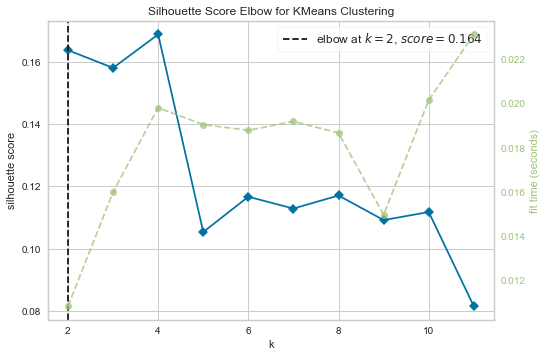

In [71]:


visualizer = KElbowVisualizer(
    model, k=(2, 12),metric="silhouette")
visualizer.fit(df_sample_scaled)    # Fit the data to the visualizer
visualizer.poof()
plt.show()

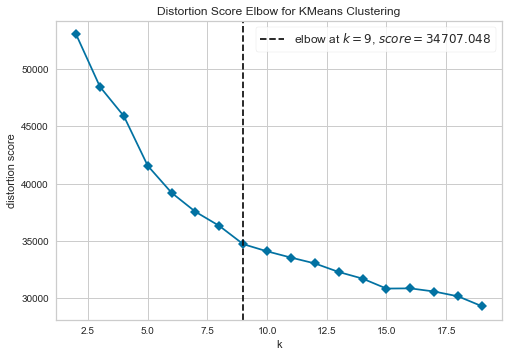

In [12]:
visualizer = KElbowVisualizer(
    model, k=(2,20), timings=False, random_state=2,metric="distortion"
)
visualizer.fit(df_sample_scaled)    # Fit the data to the visualizer
visualizer.poof()
plt.show()

In [13]:
kmeans = KMeans(n_clusters=4, init='k-means++').fit(df_sample_scaled)

C:\Users\julie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:493: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



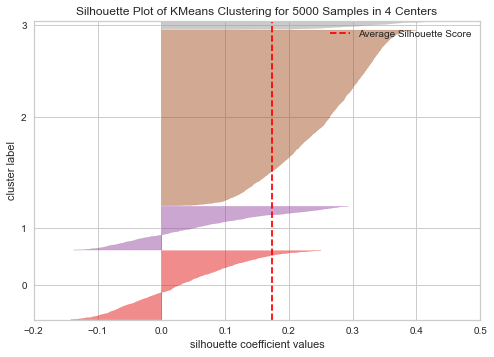

In [14]:


visualizer = SilhouetteVisualizer(kmeans)

visualizer.fit(df_sample_scaled)    # Fit the data to the visualizer
visualizer.poof()

plt.show()

In [15]:
cluster_kmeans = kmeans.fit_predict(df_sample_scaled)


In [16]:
#dataframe contenant les coordonnées provenant du t-sne 3D
df_tsne = pd.DataFrame(X_tsne,index=df_sample_scaled.index)

In [17]:
X_kmeans  = df_sample_scaled
y_kmneas = cluster_kmeans


In [18]:
X_kmeans_with_labels = np.column_stack((X_tsne, cluster_kmeans))

In [19]:
df_tsne_kmeans=pd.DataFrame(X_kmeans_with_labels,columns=['Feature_1', 'Feature_2','Feature_3', 'labels'])

In [20]:
fig = px.scatter(x=df_tsne_kmeans.iloc[:, 0],
                 y=df_tsne_kmeans.iloc[:, 1],
                 color=df_tsne_kmeans['labels'],
                 color_discrete_sequence ='paired',
                 hover_data={'Groupe': df_tsne_kmeans['labels']}
                 )

fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE")

fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers')
                  )

fig.show()

In [21]:
fig3D = px.scatter_3d(x=df_tsne_kmeans.iloc[:, 0],
                      y=df_tsne_kmeans.iloc[:, 1],
                      z=df_tsne_kmeans.iloc[:, 2],
                      
                      color_discrete_sequence='colorblind',
                      color=df_tsne_kmeans['labels'],
                      hover_data={'Groupe': df_tsne_kmeans['labels']}

                      )

fig3D.update_layout(width=1000, height=800)
fig3D.update_traces(marker=dict(size=5))

fig3D.update_layout(scene=dict(
    xaxis=dict(title='First t-SNE'), yaxis=dict(title='Second t-SNE'), zaxis=dict(title='Third t-SNE')))
fig3D.update_layout(title="Représentation 3D du Kmeans")

fig3D.show()

In [22]:
X_kmeans_with_labels = np.column_stack((X_tsne, cluster_kmeans))

In [23]:
df_umap_kmeans = np.column_stack((X_umap, cluster_kmeans))


In [24]:
df_umap_kmeans=pd.DataFrame(X_kmeans_with_labels,columns=['Feature_1', 'Feature_2','Feature_3', 'labels'])

In [25]:
fig3D = px.scatter_3d(x=df_umap.iloc[:, 0],
                      y=df_umap.iloc[:, 1],
                      z=df_umap.iloc[:, 2],
                      opacity=0.7,
                     color_discrete_sequence ='hls',
                      color=df_umap_kmeans['labels'],
                      hover_data={'Groupe':df_umap_kmeans['labels']}

                      )

fig3D.update_layout(width=1000, height=800)
fig3D.update_traces(marker=dict(size=5))

fig3D.update_layout(scene=dict(
    xaxis=dict(title='First umap'), yaxis=dict(title='Second umap'), zaxis=dict(title='Third umap')))
fig3D.update_layout(title="Représentation 3D du Kmeans - projection via UMAP")

fig3D.show()

Nous allons retenir 4 classes parmis les classes listées ci-dessous.


    
<div>
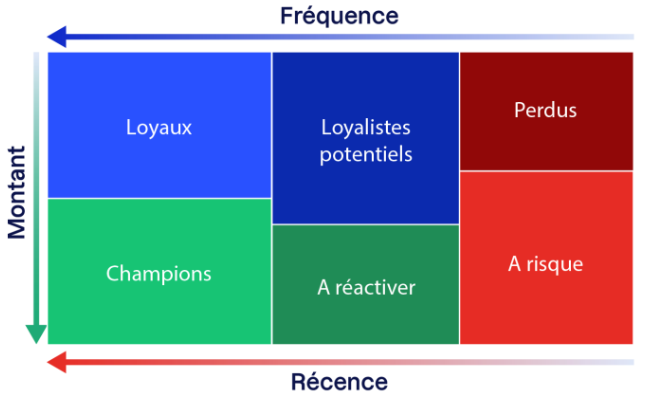
</div>

Pour déterminer les caractéristiques du clients selon son groupe d'appartenance nous ajoutons la variables comportant les numéros de groupe déterminé par le modèle

### Classification ascendante hiérarchique

In [26]:
Z = linkage(df_sample_scaled,method='ward')

In [27]:
#On indique le nombre de clusters que l'on souhaite avoir sur le dendrogramme
Nb_clusters = 10


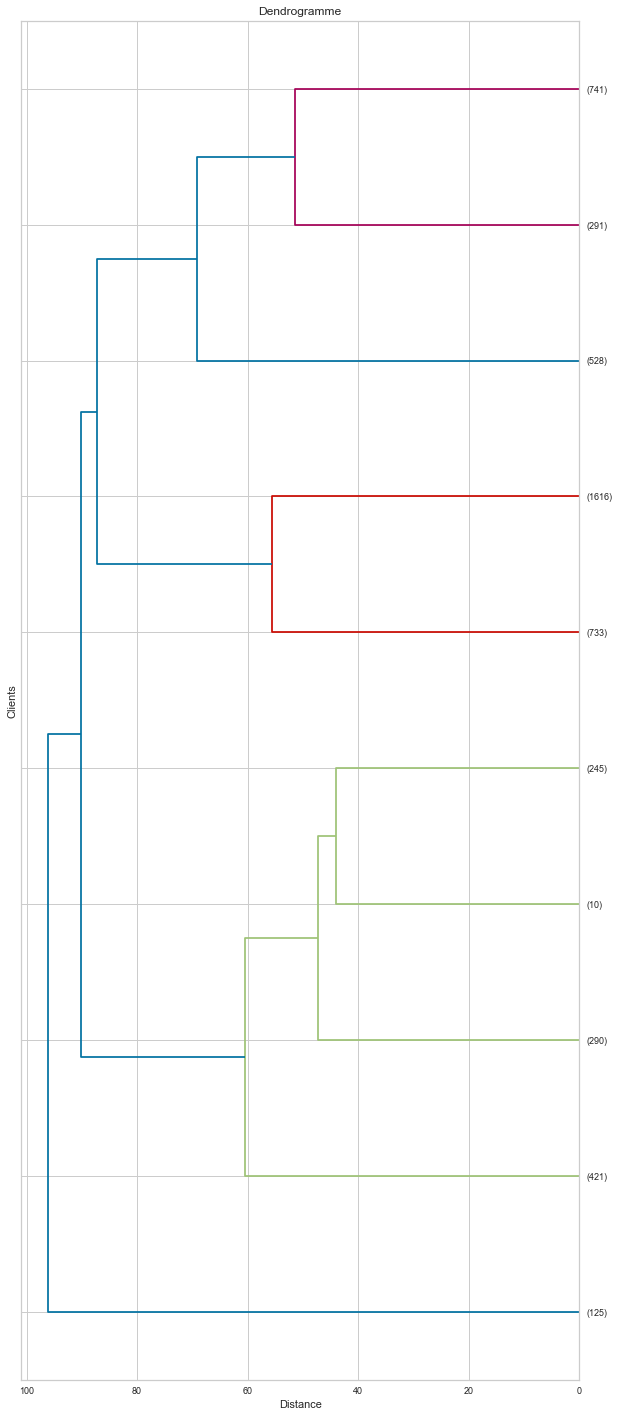

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10,25))

_ = dendrogram(Z, ax=ax,orientation="left",p= Nb_clusters,truncate_mode="lastp")

plt.title("Dendrogramme")
ax.set_xlabel("Distance")
ax.set_ylabel("Clients")
ax.tick_params(axis='x', which='major', labelsize=9)
ax.tick_params(axis='y', which='major', labelsize=9)


In [29]:
# On fixe le nombre de groupes avec la méthode du saut maximum
threshold = 80
clusters_CAH = fcluster(Z, threshold, criterion='distance')
df_CAH = df_sample_scaled.copy()
df_CAH['GroupCAH'] = clusters_CAH

In [30]:
df_CAH['GroupCAH'].nunique()

4

In [31]:
X_CAH_with_labels = np.column_stack((X_tsne, clusters_CAH))

In [32]:
df_tsne_CAH = pd.DataFrame(X_CAH_with_labels,columns=['Feature_1', 'Feature_2','Feature_3', 'labels'])

In [33]:
fig3D = px.scatter_3d(x=df_tsne_CAH.iloc[:, 0],
                      y=df_tsne_CAH.iloc[:, 1],
                      z=df_tsne_CAH.iloc[:, 2],
                      color=df_tsne_CAH['labels'],
                      hover_data={'Groupe': df_tsne_CAH['labels']}

                      )

fig3D.update_layout(width=1000, height=800)
fig3D.update_traces(marker=dict(size=4),
                    selector=dict(mode='markers'))

fig3D.update_layout(scene=dict(
    xaxis=dict(title='First t-SNE'), yaxis=dict(title='Second t-SNE'), zaxis=dict(title='Third t-SNE')))
fig3D.update_layout(title="Représentation 3D CAH")

fig3D.show()

In [34]:
X_umap_CAH_with_labels = np.column_stack((X_umap,  clusters_CAH))

In [35]:
df_umap_CAH = df_umap.merge(df_CAH['GroupCAH'],left_index=True,right_index=True, how = 'left')


In [36]:
fig3D = px.scatter_3d(x=df_umap_CAH.iloc[:, 0],
                      y=df_umap_CAH.iloc[:, 1],
                      z=df_umap_CAH.iloc[:, 2],
                      opacity=0.7,
                      color_discrete_sequence='colorblind',
                      color=df_umap_CAH['GroupCAH'],
                      hover_data={'Groupe': df_umap_CAH['GroupCAH']}

                      )

fig3D.update_layout(width=1000, height=800)
fig3D.update_traces(marker=dict(size=4))


fig3D.update_layout(scene=dict(
    xaxis=dict(title='First umap'), yaxis=dict(title='Second umap'), zaxis=dict(title='Third umap')))
fig3D.update_layout(title="Représentation 3D du Kmeans - projection via UMAP")

fig3D.show()

In [37]:
df_sample_scaled.iloc[:,7:46]

delay  payment_type_boleto  \
customer_unique_id                                                
5503225a48ae360aa5d1957bd64aa725 -2.520609                    0   
e784adf58bfebc64345aa6b16186de95  1.648401                    0   
765c769773759b7ec5d53fdb85833c72 -0.486946                    1   
09b9f8efd35809e5e8e5f58b0588dac9  0.733253                    1   
47bd37533335ca8fcfb008e49157199b -0.080213                    0   
...                                    ...                  ...   
f8e8ca028ca531040f0776d683855461  2.461867                    1   
a7f680dafd814cd6fe5b37cd0e623a5a  0.224837                    0   
afec543ab3afb92e608260f0a9ac597e -0.690312                    0   
3438b8441c857ae2e12fb185b58ec074 -2.723976                    0   
648ae5c558ecc43d477741e8b3f6bb07 -0.080213                    0   

                                  payment_type_credit_card  \
customer_unique_id                                           
5503225a48ae360aa5d1957bd64aa725                         1   
e784adf58bfebc64345aa6b16186de95                         1   
765c769773759b7ec5d53fdb85833c72                         0   
09b9f8efd35809e5e8e5f58b0588dac9                         0   
47bd37533335ca8fcfb008e49157199b                         2   
...                                                    ...   
f8e8ca028ca531040f0776d683855461                         0   
a7f680dafd814cd6fe5b37cd0e623a5a                         1   
afec543ab3afb92e608260f0a9ac597e                         1   
3438b8441c857ae2e12fb185b58ec074                         1   
648ae5c558ecc43d477741e8b3f6bb07                         1   

                                  payment_type_debit_card  \
customer_unique_id                                          
5503225a48ae360aa5d1957bd64aa725                        0   
e784adf58bfebc64345aa6b16186de95                        0   
765c769773759b7ec5d53fdb85833c72                        0   
09b9f8efd35809e5e8e5f58b0588dac9                        0   
47bd37533335ca8fcfb008e49157199b                        0   
...                                                   ...   
f8e8ca028ca531040f0776d683855461                        0   
a7f680dafd814cd6fe5b37cd0e623a5a                        0   
afec543ab3afb92e608260f0a9ac597e                        0   
3438b8441c857ae2e12fb185b58ec074                        0   
648ae5c558ecc43d477741e8b3f6bb07                        0   

                                  payment_type_not_defined  \
customer_unique_id                                           
5503225a48ae360aa5d1957bd64aa725                         0   
e784adf58bfebc64345aa6b16186de95                         0   
765c769773759b7ec5d53fdb85833c72                         0   
09b9f8efd35809e5e8e5f58b0588dac9                         0   
47bd37533335ca8fcfb008e49157199b                         0   
...                                                    ...   
f8e8ca028ca531040f0776d683855461                         0   
a7f680dafd814cd6fe5b37cd0e623a5a                         0   
afec543ab3afb92e608260f0a9ac597e                         0   
3438b8441c857ae2e12fb185b58ec074                         0   
648ae5c558ecc43d477741e8b3f6bb07                         0   

                                  payment_type_voucher  \
customer_unique_id                                       
5503225a48ae360aa5d1957bd64aa725                     0   
e784adf58bfebc64345aa6b16186de95                     0   
765c769773759b7ec5d53fdb85833c72                     0   
09b9f8efd35809e5e8e5f58b0588dac9                     0   
47bd37533335ca8fcfb008e49157199b                     0   
...                                                ...   
f8e8ca028ca531040f0776d683855461                     0   
a7f680dafd814cd6fe5b37cd0e623a5a                     0   
afec543ab3afb92e608260f0a9ac597e                     0   
3438b8441c857ae2e12fb185b58ec074                     0   
648ae5c558ecc43d477741e8b3f6bb07                     0   

  

## K-Prototype

In [38]:
df_train.head()

avg_prod_vol  avg_prod_weight  \
customer_unique_id                                                
861eff4711a542e4b93843c6dd7febb0        6000.0            563.0   
290c77bc529b7ac935b93aa66c333dc3       53400.0            563.0   
060e732b5b29e8181a18229c7b0b2b5e       45968.0            563.0   
259dac757896d24d7702b9acbbff3f3c        6000.0            563.0   
345ecd01c38d18a9036ed96c73b8d066       23625.0           5200.0   

                                  median_review_score  recency  monetary  \
customer_unique_id                                                         
861eff4711a542e4b93843c6dd7febb0                  4.0    519.0    146.87   
290c77bc529b7ac935b93aa66c333dc3                  5.0    277.0    335.48   
060e732b5b29e8181a18229c7b0b2b5e                  5.0    151.0    157.73   
259dac757896d24d7702b9acbbff3f3c                  5.0    218.0    173.30   
345ecd01c38d18a9036ed96c73b8d066                  5.0     80.0    252.25   

                                  frequency  delivery_time  delay  \
customer_unique_id                                                  
861eff4711a542e4b93843c6dd7febb0        1.0            8.0   10.0   
290c77bc529b7ac935b93aa66c333dc3        1.0           16.0    7.0   
060e732b5b29e8181a18229c7b0b2b5e        1.0           26.0   -2.0   
259dac757896d24d7702b9acbbff3f3c        1.0           14.0   12.0   
345ecd01c38d18a9036ed96c73b8d066        1.0           11.0    5.0   

                                  payment_type_boleto  \
customer_unique_id                                      
861eff4711a542e4b93843c6dd7febb0                    0   
290c77bc529b7ac935b93aa66c333dc3                    0   
060e732b5b29e8181a18229c7b0b2b5e                    0   
259dac757896d24d7702b9acbbff3f3c                    0   
345ecd01c38d18a9036ed96c73b8d066                    0   

                                  payment_type_credit_card  \
customer_unique_id                                           
861eff4711a542e4b93843c6dd7febb0                         1   
290c77bc529b7ac935b93aa66c333dc3                         1   
060e732b5b29e8181a18229c7b0b2b5e                         1   
259dac757896d24d7702b9acbbff3f3c                         1   
345ecd01c38d18a9036ed96c73b8d066                         1   

                                  payment_type_debit_card  \
customer_unique_id                                          
861eff4711a542e4b93843c6dd7febb0                        0   
290c77bc529b7ac935b93aa66c333dc3                        0   
060e732b5b29e8181a18229c7b0b2b5e                        0   
259dac757896d24d7702b9acbbff3f3c                        0   
345ecd01c38d18a9036ed96c73b8d066                        0   

                                  payment_type_not_defined  \
customer_unique_id                                           
861eff4711a542e4b93843c6dd7febb0                         0   
290c77bc529b7ac935b93aa66c333dc3                         0   
060e732b5b29e8181a18229c7b0b2b5e                         0   
259dac757896d24d7702b9acbbff3f3c                         0   
345ecd01c38d18a9036ed96c73b8d066                         0   

                                  payment_type_voucher  \
customer_unique_id                                       
861eff4711a542e4b93843c6dd7febb0                     0   
290c77bc529b7ac935b93aa66c333dc3                     0   
060e732b5b29e8181a18229c7b0b2b5e                     0   
259dac757896d24d7702b9acbbff3f3c                     0   
345ecd01c38d18a9036ed96c73b8d066                     0   

                                  prod_cat_t10_automotivo  \
customer_unique_id                                          
861eff4711a542e4b93843c6dd7febb0                        0   
290c77bc529b7ac935b93aa66c333dc3                        0   
060e732b5b29e8181a18229c7b0b2b5e                        0   
259dac757896d24d7702b9acbbff3f3c                        0   
345ecd01c38d18a9036ed96c73b8d066                        0   

              

In [39]:
kproto = KPrototypes(n_clusters=4, init='Cao', verbose=2)


Initialization method and algorithm are deterministic. Setting n_init to 1.


In [40]:
cluster_kproto = kproto.fit_predict(df_sample_scaled, categorical=list(range(8,46)))


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 1266, ncost: 32189.409306851012
Run: 1, iteration: 2/100, moves: 471, ncost: 31760.266705700367
Run: 1, iteration: 3/100, moves: 204, ncost: 31689.769261216246
Run: 1, iteration: 4/100, moves: 85, ncost: 31670.902160513535
Run: 1, iteration: 5/100, moves: 44, ncost: 31666.08264856077
Run: 1, iteration: 6/100, moves: 25, ncost: 31663.67819516998
Run: 1, iteration: 7/100, moves: 36, ncost: 31658.71469290388
Run: 1, iteration: 8/100, moves: 40, ncost: 31647.546946062695
Run: 1, iteration: 9/100, moves: 31, ncost: 31642.546489717384
Run: 1, iteration: 10/100, moves: 30, ncost: 31637.88183724682
Run: 1, iteration: 11/100, moves: 20, ncost: 31635.977794267055
Run: 1, iteration: 12/100, moves: 7, ncost: 31635.742821099033
Run: 1, iteration: 13/100, moves: 0, ncost: 31635.742821099033
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 

Run: 9, iteration: 2/100, moves: 548, ncost: 34290.12354519666
Run: 9, iteration: 3/100, moves: 236, ncost: 34142.29050794493
Run: 9, iteration: 4/100, moves: 106, ncost: 34114.63163702151
Run: 9, iteration: 5/100, moves: 49, ncost: 34107.40774081195
Run: 9, iteration: 6/100, moves: 24, ncost: 34105.55488139729
Run: 9, iteration: 7/100, moves: 20, ncost: 34103.8237083971
Run: 9, iteration: 8/100, moves: 13, ncost: 34102.50488821756
Run: 9, iteration: 9/100, moves: 14, ncost: 34101.354982282486
Run: 9, iteration: 10/100, moves: 9, ncost: 34100.59761021041
Run: 9, iteration: 11/100, moves: 9, ncost: 34100.14024849627
Run: 9, iteration: 12/100, moves: 12, ncost: 34099.38656158307
Run: 9, iteration: 13/100, moves: 16, ncost: 34098.28711727619
Run: 9, iteration: 14/100, moves: 9, ncost: 34097.801834314465
Run: 9, iteration: 15/100, moves: 5, ncost: 34097.24711108982
Run: 9, iteration: 16/100, moves: 23, ncost: 34092.963043360105
Run: 9, iteration: 17/100, moves: 31, ncost: 34086.21732399554

In [41]:
df_Kproto = df_sample_scaled.copy()
df_Kproto['labels'] = cluster_kproto
df_Kproto['labels'] =df_Kproto['labels'].astype('int32')


In [42]:
df_Kproto_tsne = df_tsne.merge(df_Kproto['labels'],left_index=True,right_index=True, how = 'left')
df_Kproto_tsne

0          1          2  labels
customer_unique_id                                                       
5503225a48ae360aa5d1957bd64aa725  20.821394   8.176568   1.522505       3
e784adf58bfebc64345aa6b16186de95   1.721645 -21.122610   4.358075       0
765c769773759b7ec5d53fdb85833c72  -4.934410 -19.114159 -12.567310       1
09b9f8efd35809e5e8e5f58b0588dac9  11.809933  -2.082262 -22.280594       1
47bd37533335ca8fcfb008e49157199b   8.201892 -12.323055  -2.191939       1
...                                     ...        ...        ...     ...
f8e8ca028ca531040f0776d683855461 -13.462321  10.909681  15.407168       0
a7f680dafd814cd6fe5b37cd0e623a5a  16.043430  -0.667383   8.404616       0
afec543ab3afb92e608260f0a9ac597e   7.287154   7.842567   0.787118       3
3438b8441c857ae2e12fb185b58ec074  24.798025   6.545862  -2.267782       3
648ae5c558ecc43d477741e8b3f6bb07  -6.420080  -3.127262   8.823154       0

[5000 rows x 4 columns]

In [43]:
fig3D = px.scatter_3d(x=df_Kproto_tsne.iloc[:, 0],
                      y=df_Kproto_tsne.iloc[:, 1],
                      z=df_Kproto_tsne.iloc[:, 2],
                      color=df_Kproto_tsne['labels'],
                      hover_data={'Groupe': df_Kproto_tsne['labels']}

                      )

fig3D.update_layout(width=1000, height=800)
fig3D.update_traces(marker=dict(size=5))

fig3D.update_layout(scene=dict(
    xaxis=dict(title='First t-SNE'), yaxis=dict(title='Second t-SNE'), zaxis=dict(title='Third t-SNE')))
fig3D.update_layout(title="Représentation 3D du Kprototype")

fig3D.show()

In [44]:
X_umap_Kproto_with_labels = np.column_stack((X_umap,  cluster_kproto))

In [45]:
df_umap_Kproto = pd.DataFrame(X_umap_Kproto_with_labels,columns=['Feature_1', 'Feature_2','Feature_3', 'labels'])

In [46]:
fig3D = px.scatter_3d(x=df_umap_Kproto.iloc[:, 0],
                      y=df_umap_Kproto.iloc[:, 1],
                      z=df_umap_Kproto.iloc[:, 2],
                      opacity=0.7,
                      
                      color=df_Kproto_tsne['labels'],
                      hover_data={'Groupe': df_Kproto_tsne['labels']}

                      )

fig3D.update_layout(width=1000, height=800)
# fig3D.update_traces(marker=dict(size=12,
#                               line=dict(width=2,
#                                         color='#14140F')),
#                   selector=dict(mode='markers'))

fig3D.update_layout(scene=dict(
    xaxis=dict(title='First umap'), yaxis=dict(title='Second umap'), zaxis=dict(title='Third umap')))
fig3D.update_layout(title="Représentation 3D du Kmeans - projection via UMAP")

fig3D.show()

## Bilan comparatif des scores silhoutte des différents modèles

Nous baserons notre choix de modèle sur la comparaison des scores silhouette.

In [47]:
df_silhoutte_summary = pd.DataFrame({'kmeans': [silhouette_score(df_sample_scaled, cluster_kmeans)],
                                    'CAH': [silhouette_score(df_sample_scaled, clusters_CAH)],
                                    'kprototype': [silhouette_score(df_sample_scaled, cluster_kproto)]}, index = ['Silhouette'])
df_silhoutte_summary

kmeans       CAH  kprototype
Silhouette  0.172715  0.115833    0.168105

***

# 4-INTERPRETATION DES RESULTATS DE CLASSIFICATION

Afin de comprendre le fonctionnement de notre modèle nous réalisons une classification supervisée sur la base du jeu de donnée qui a reçu les différentes classes au travers du modèle utilisé précédemment.

In [48]:
X = df_Kproto.drop('labels',axis=1)

In [49]:
y = df_Kproto['labels']

In [50]:
xgboost = xgb.XGBClassifier(objective="binary:logistic")

xgboost.fit(X,y)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [51]:
explainer = shap.TreeExplainer(xgboost)


In [52]:
shap_values = explainer.shap_values(X)

In [53]:
np.shape(shap_values)

(5000, 51, 4)

In [54]:
# shap.plots.force(explainer.expected_value[0], shap_values[0,:,1])

<br>Nous commençons par tenter d'explique l'influence des variables sur notre modèle pour chaque classe </br>

In [55]:
shap_values_explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X)


Variables influentes pour la première catégorie

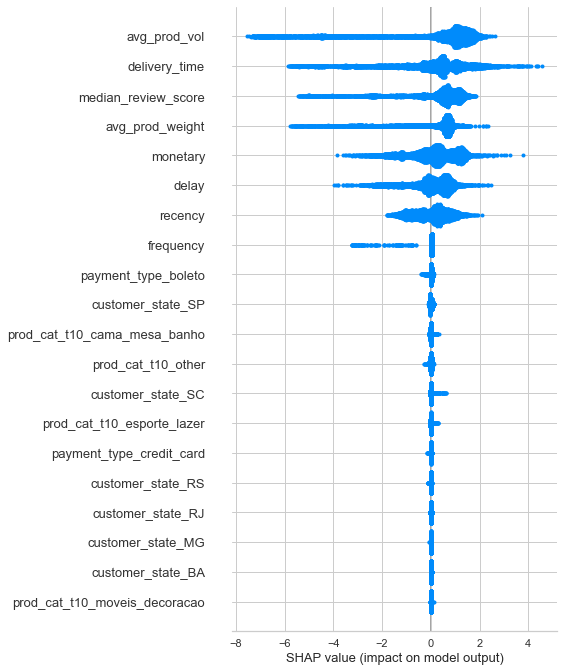

In [56]:
shap.summary_plot(shap_values[:, :, 0], feature_names=X.columns)

Variables influentes pour la seconde catégorie

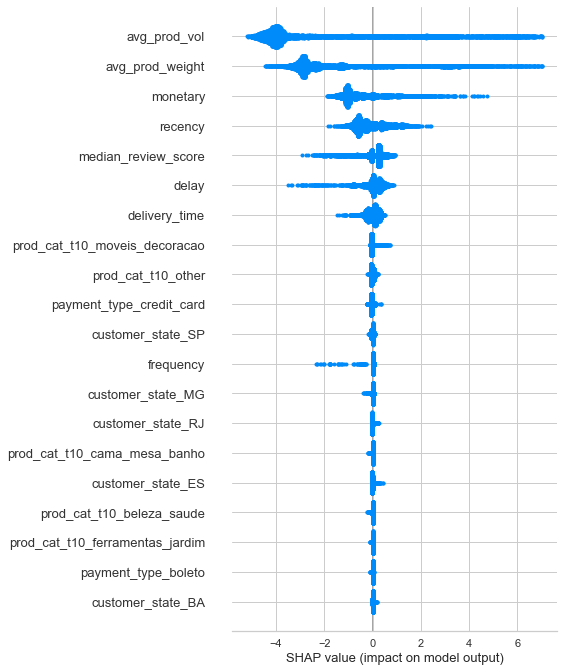

In [57]:
shap.summary_plot(shap_values[:, :, 1], feature_names=X.columns)

Variables influentes pour la troisième catégorie

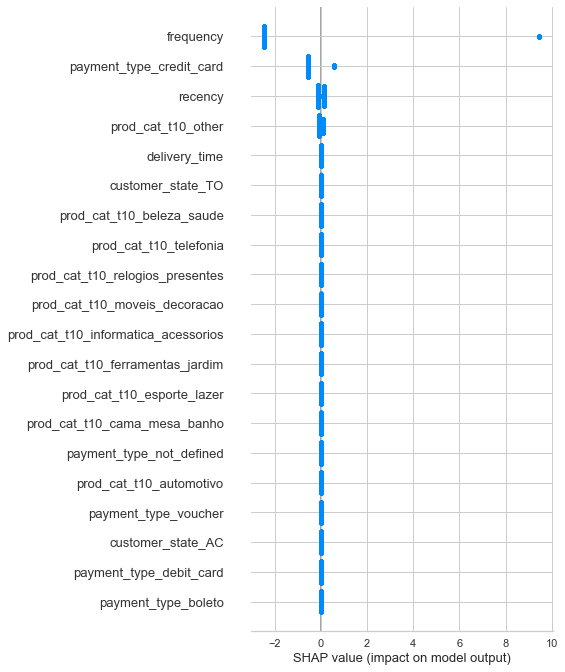

In [58]:
shap.summary_plot(shap_values[:, :, 2], feature_names=X.columns)

Variables influentes pour la quatrième catégorie

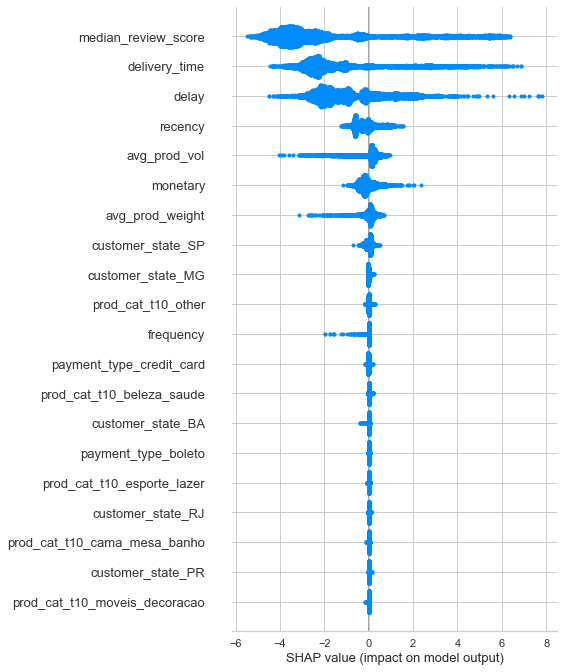

In [59]:
shap.summary_plot(shap_values[:, :, 3], feature_names=X.columns)

In [60]:
shap.force_plot(explainer.expected_value[2], shap_values[50, :, 1], X.iloc[50])

In [61]:
shap.force_plot(explainer.expected_value[2], shap_values[4, :, 1], X.iloc[4])

In [62]:
shap.force_plot(explainer.expected_value[1], shap_values[2, :, 1], X.iloc[2])

In [63]:
shap.force_plot(explainer.expected_value[3],
                shap_values[123, :, 3], X.iloc[123])

In [64]:
# shap.force_plot(explainer.expected_value[class_idx], shap_values[individu_idx,:,class_idx], X_test.iloc[individu_idx,:])
shap.force_plot(explainer.expected_value[0],
                shap_values[2016, :, 0], X.iloc[2016, :])

Les différentes interprétations du modèle ( globales et locales) seront développées dans la présentation.

Dans la dernière partie nous allons évaluer la stabilité de notre modèle dans le temps.